MiniSOM Tutorial for 2-D Atmospheric Data and Example Using Mean Sea Level Pressure Data 

Bsckground on Self Organizing Maps (SOMs)
Self-organizing Maps, SOMs, are a form of unsupervised learning that utilizes a competitive neural network to cluster alike data. SOMs are like the clustering technique used in K-means. SOMs take multidimensional data and reduce it to a two-dimensional array that can be easily visualized. Patterns that share similar characteristics are grouped adjacent to one another; whereas patterns that share minimal similarities are grouped on opposing sides of the SOM. 

MiniSOM Tutorial: This notebook will generate the SOMs themselves, plot the frequencies, sammon maps, and the SOM anomaly plots. This is Step #2 in the MiniSOM Tutorial for 2-D Atmospheric Data and Example Using Mean Sea Level Pressure Data.

Imports for the Code:

In [103]:
#Imports 
import xarray as xr
import numpy as np
import pandas as pd
import warnings
import minisom
import pickle
from minisom import asymptotic_decay
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from numpy import savetxt
from numpy import loadtxt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import matplotlib.pyplot as plt
import os
from itertools import product

Functions Used in the Code:

In [128]:
#Functions Used in the Code
def getList(dict):
    list = []
    for key in winmap.keys():
        list.append(key)
        
    return list
def sammon(x, n, display = 2, inputdist = 'raw', maxhalves = 20, maxiter = 500, tolfun = 1e-9, init = 'default'):

    import numpy as np 
    from scipy.spatial.distance import cdist

    """Perform Sammon mapping on dataset x
    y = sammon(x) applies the Sammon nonlinear mapping procedure on
    multivariate data x, where each row represents a pattern and each column
    represents a feature.  On completion, y contains the corresponding
    co-ordinates of each point on the map.  By default, a two-dimensional
    map is created.  Note if x contains any duplicated rows, SAMMON will
    fail (ungracefully). 
    [y,E] = sammon(x) also returns the value of the cost function in E (i.e.
    the stress of the mapping).
    An N-dimensional output map is generated by y = sammon(x,n) .
    A set of optimisation options can be specified using optional
    arguments, y = sammon(x,n,[OPTS]):
       maxiter        - maximum number of iterations
       tolfun         - relative tolerance on objective function
       maxhalves      - maximum number of step halvings
       input          - {'raw','distance'} if set to 'distance', X is 
                        interpreted as a matrix of pairwise distances.
       display        - 0 to 2. 0 least verbose, 2 max verbose.
       init           - {'pca', 'cmdscale', random', 'default'}
                        default is 'pca' if input is 'raw', 
                        'msdcale' if input is 'distance'
    The default options are retrieved by calling sammon(x) with no
    parameters.
    File        : sammon.py
    Date        : 18 April 2014
    Authors     : Tom J. Pollard (tom.pollard.11@ucl.ac.uk)
                : Ported from MATLAB implementation by 
                  Gavin C. Cawley and Nicola L. C. Talbot
    Description : Simple python implementation of Sammon's non-linear
                  mapping algorithm [1].
    References  : [1] Sammon, John W. Jr., "A Nonlinear Mapping for Data
                  Structure Analysis", IEEE Transactions on Computers,
                  vol. C-18, no. 5, pp 401-409, May 1969.
    Copyright   : (c) Dr Gavin C. Cawley, November 2007.
    This program is free software; you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation; either version 2 of the License, or
    (at your option) any later version.
    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.
    You should have received a copy of the GNU General Public License
    along with this program; if not, write to the Free Software
    Foundation, Inc., 59 Temple Place, Suite 330, Boston, MA 02111-1307 USA
    """

    # Create distance matrix unless given by parameters
    if inputdist == 'distance':
        D = x
        if init == 'default':
            init = 'cmdscale'
    else:
        D = cdist(x, x)
        if init == 'default':
            init = 'pca'

    if inputdist == 'distance' and init == 'pca':
        raise ValueError("Cannot use init == 'pca' when inputdist == 'distance'")

    if np.count_nonzero(np.diagonal(D)) > 0:
        raise ValueError("The diagonal of the dissimilarity matrix must be zero")

    # Remaining initialisation
    N = x.shape[0]
    scale = 0.5 / D.sum()
    D = D + np.eye(N)     

    if np.count_nonzero(D<=0) > 0:
        raise ValueError("Off-diagonal dissimilarities must be strictly positive")   

    Dinv = 1 / D
    if init == 'pca':
        [UU,DD,_] = np.linalg.svd(x)
        y = UU[:,:n]*DD[:n] 
    elif init == 'cmdscale':
        from cmdscale import cmdscale
        y,e = cmdscale(D)
        y = y[:,:n]
    else:
        y = np.random.normal(0.0,1.0,[N,n])
    one = np.ones([N,n])
    d = cdist(y,y) + np.eye(N)
    dinv = 1. / d
    delta = D-d 
    E = ((delta**2)*Dinv).sum() 

    # Get on with it
    for i in range(maxiter):

        # Compute gradient, Hessian and search direction (note it is actually
        # 1/4 of the gradient and Hessian, but the step size is just the ratio
        # of the gradient and the diagonal of the Hessian so it doesn't
        # matter).
        delta = dinv - Dinv
        deltaone = np.dot(delta,one)
        g = np.dot(delta,y) - (y * deltaone)
        dinv3 = dinv ** 3
        y2 = y ** 2
        H = np.dot(dinv3,y2) - deltaone - np.dot(2,y) * np.dot(dinv3,y) + y2 * np.dot(dinv3,one)
        s = -g.flatten(order='F') / np.abs(H.flatten(order='F'))
        y_old    = y

        # Use step-halving procedure to ensure progress is made
        for j in range(maxhalves):
            s_reshape = np.reshape(s, (-1,n),order='F')
            y = y_old + s_reshape
            d = cdist(y, y) + np.eye(N)
            dinv = 1 / d
            delta = D - d
            E_new = ((delta**2)*Dinv).sum()
            if E_new < E:
                break
            else:
                s = 0.5*s

        # Bomb out if too many halving steps are required
        if j == maxhalves-1:
            print('Warning: maxhalves exceeded. Sammon mapping may not converge...')

        # Evaluate termination criterion
        if abs((E - E_new) / E) < tolfun:
            if display:
                print('TolFun exceeded: Optimisation terminated')
            break

        # Report progress
        E = E_new
        if display > 1:
            print('epoch = %d : E = %12.10f'% (i+1, E * scale))

    if i == maxiter-1:
        print('Warning: maxiter exceeded. Sammon mapping may not have converged...')

    # Fiddle stress to match the original Sammon paper
    E = E * scale
    
    return [y,E]

def getList(dict):
    list = []
    for key in winmap.keys():
        list.append(key)      
    return list

You will need to open the data_train that we saved from the SOM Step #1

In [93]:
#State the path where the file is located
PATH = '/Users/research/thesis_code/SOMs/'  #This is the path where the data files are stored.
PATH_SAVE = '/Users/research/thesis_code/SOMs_TEST/'  #This is the folder where we will save the SOMs themselves as well as the plots for each SOM.

data_train = np.load('TEST2_som_data_train.npy')
data_train.shape

(604, 216)

Define the parameters for the SOM:
Please refer to https://github.com/JustGlowing/minisom/blob/master/minisom.py for full documentation on the functions/parameters of MiniSOM

In [94]:
#You want to change these to the settings that you would like. 
x= 4 #columns
y= 3 #row
input_length = 216 #This is value is the the length of the latitude X longitude. It is the second value in the data_train.shape step. 
sigma = 2         #The sigma value must be y-1. 
learning_rate = 0.0005  #Learning Rate 
qerror_list = []
q_win = 100000.

We will now generate the SOMs themselves. This is an iterative process. For this tutorial, the SOMs will be generated using a 1-Step process; however, SOMs can be made using a 2-Step process as well. 

In [95]:
for i in range(10):   #The number of SOMs that will be generated. 
    # initialize random weights
    era5_hourly_som1 = minisom.MiniSom(y,x, input_len = input_length, sigma = sigma, learning_rate=learning_rate, neighborhood_function='bubble', decay_function = asymptotic_decay)
    era5_hourly_som1.random_weights_init(data_train)
    # train som
    era5_hourly_som1.train(data_train, num_iteration=100000,random_order=True, verbose=True)
    q_error = era5_hourly_som1.quantization_error(data_train)
    
    #Add the details of the SOM settings into the name of the file so that you know what the SOM is showing.
    with open(PATH_SAVE + '06122023_4by3_LR0.0005_sig2_SOM_som_'+str(i)+'.p', 'wb') as outfile: #this is how you save the file, the str(i) is a unique name
        pickle.dump(era5_hourly_som1, outfile)
    weights = era5_hourly_som1._weights
    qerror_list += [q_error]
    i+=1
    if q_error < q_win:
        q_win = q_error
        win_weights = era5_hourly_som1

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 86.33053304782472
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 86.00361462045076
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 85.73766262369291
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 86.80281112257934
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 87.55796237289029
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 85.11501361296939
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 85.72436887523554
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 84.75665759259144
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 85.44200198796526
 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 85.59681683070711


We will now open the remaining variables that were saved from Step #1. We will need these variables for plotting.

In [114]:
time_values = np.load('TEST_som_time_data.npy')
mslpraw = xr.open_dataset('/Users/research/thesis_code/SOM_MSLPraw_NCEP_data.nc')
mslp = mslpraw['mslp'].values
mslp_SOM = mslpraw['mslp']
lon = mslpraw['lon'].values
lat = mslpraw['lat'].values
nx = int((mslpraw['lat'].size))
ny = int((mslpraw['lon'].size))
nhours =int((mslpraw['time'].size))

We will begin by plotting the frequency Plots and then the Sammon Plots for each SOM made. 

In [96]:
#Set the SOM Columns and the Rows 
som_col = 4
som_row = 3
x_coor = 4
y_coor= 3

folderpath = '\\Users\\research\\thesis_code\\SOMs_TEST\\'  #This is where all your SOMs were saved

names = ([os.path.splitext(os.path.split(x)[-1])[0] for x in glob.glob("\\Users\\research\\thesis_code\\SOMs_TEST\\06122023_4by3_LR0.0005_sig2_SOM_som_*")]) #this might be different for you

#but this is just grabbing the first few characters of my names of my file (see above how I named them, for example som_8

filepaths = glob.glob("\\Users\\research\\thesis_code\\SOMs_TEST\\06122023_4by3_LR0.0005_sig2_SOM_som_*") #this is showing the path and the given file

print(names)

['06122023_4by3_LR0.0005_sig2_SOM_som_0', '06122023_4by3_LR0.0005_sig2_SOM_som_1', '06122023_4by3_LR0.0005_sig2_SOM_som_2', '06122023_4by3_LR0.0005_sig2_SOM_som_3', '06122023_4by3_LR0.0005_sig2_SOM_som_4', '06122023_4by3_LR0.0005_sig2_SOM_som_5', '06122023_4by3_LR0.0005_sig2_SOM_som_6', '06122023_4by3_LR0.0005_sig2_SOM_som_7', '06122023_4by3_LR0.0005_sig2_SOM_som_8', '06122023_4by3_LR0.0005_sig2_SOM_som_9']


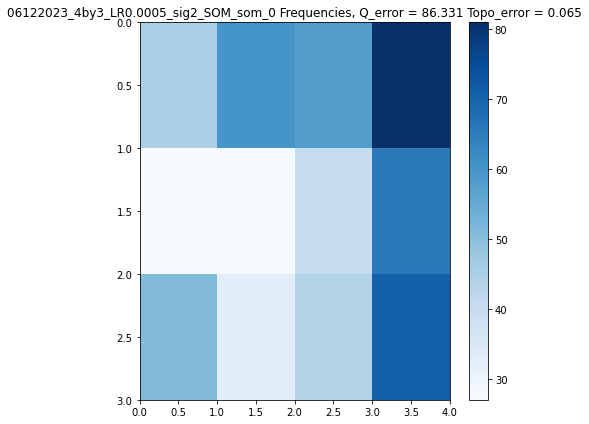

TolFun exceeded: Optimisation terminated


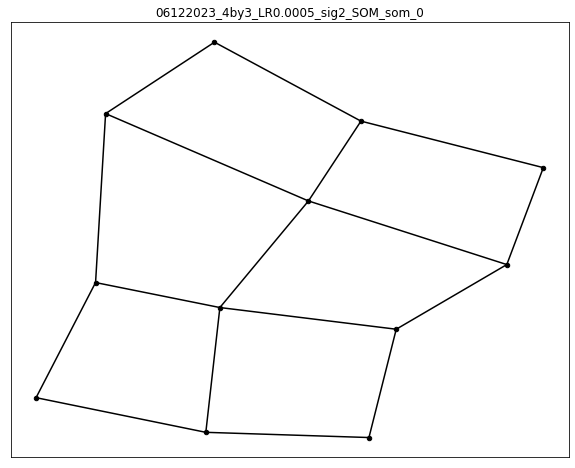

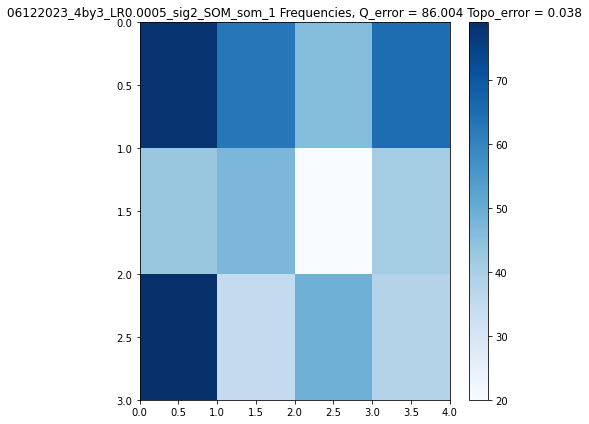

TolFun exceeded: Optimisation terminated


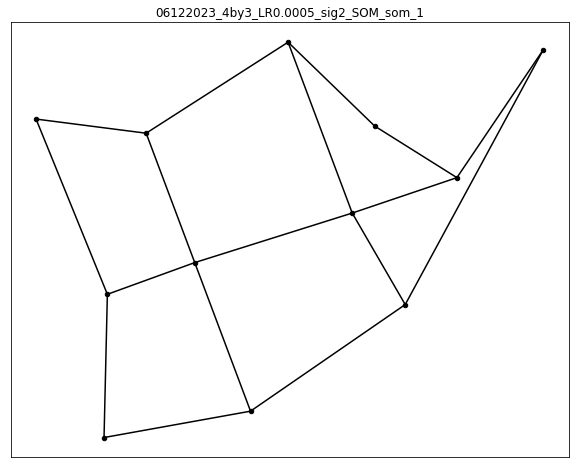

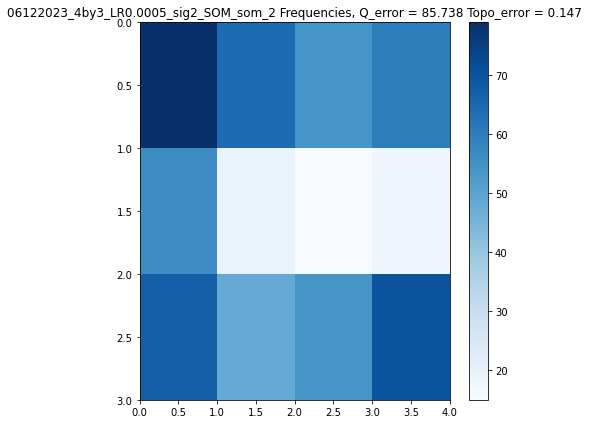

TolFun exceeded: Optimisation terminated


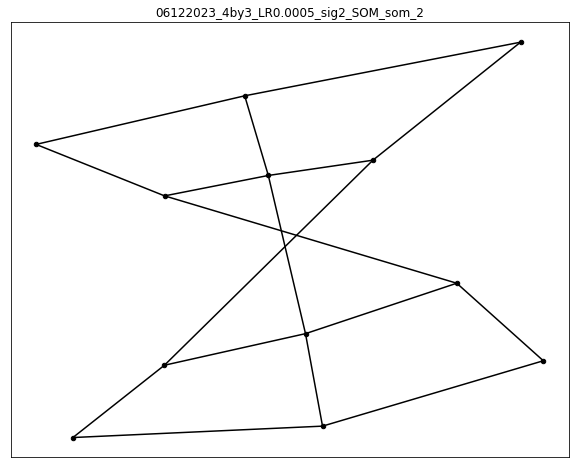

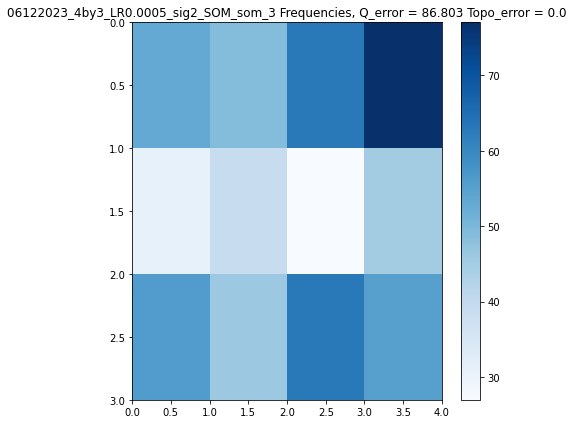

TolFun exceeded: Optimisation terminated


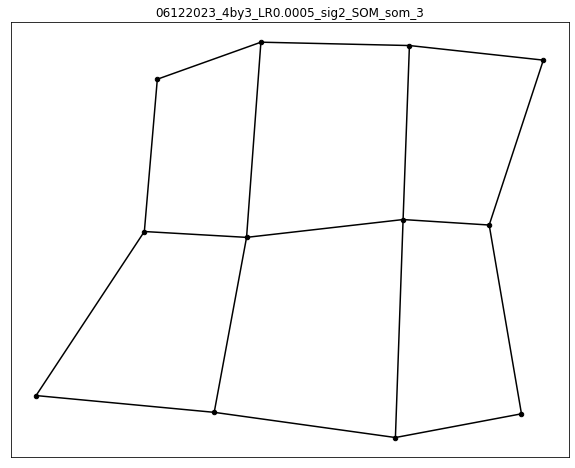

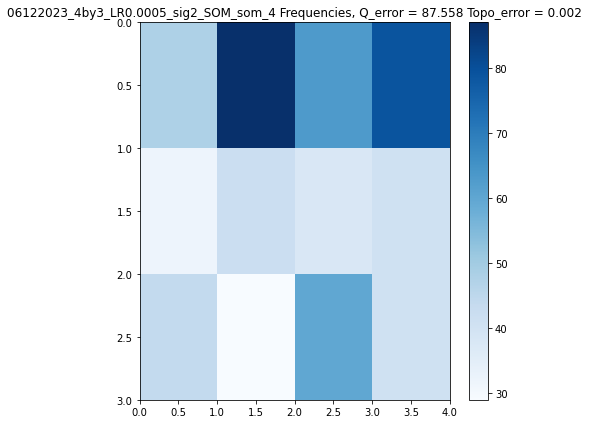

TolFun exceeded: Optimisation terminated


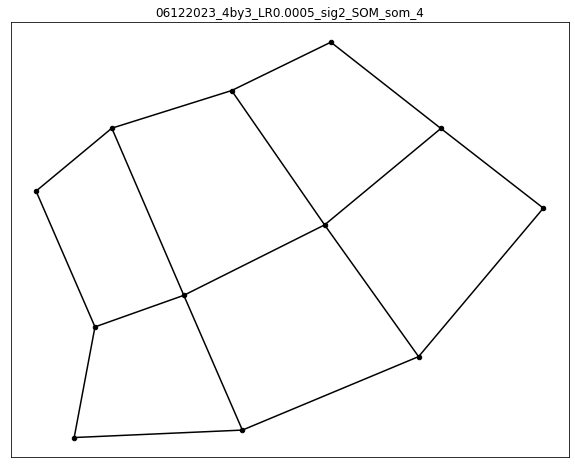

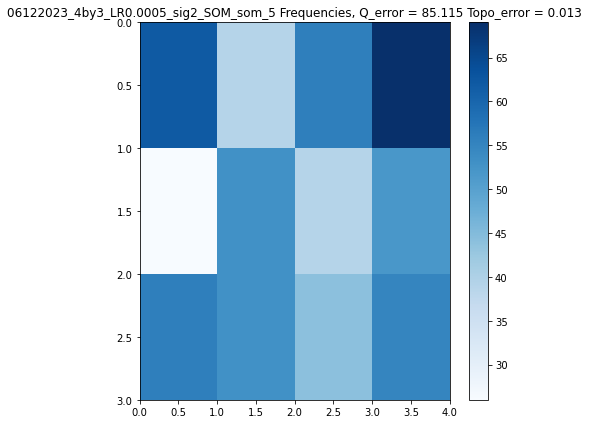

TolFun exceeded: Optimisation terminated


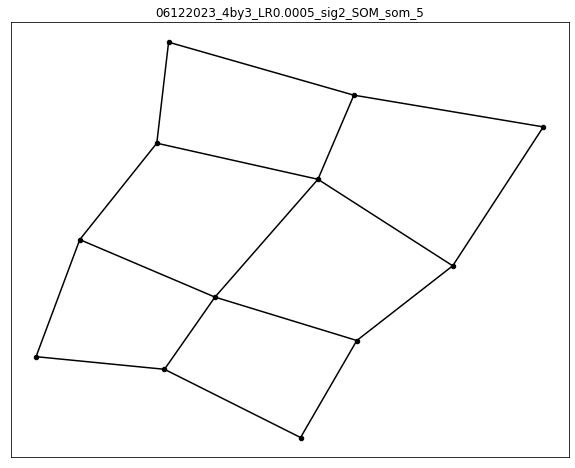

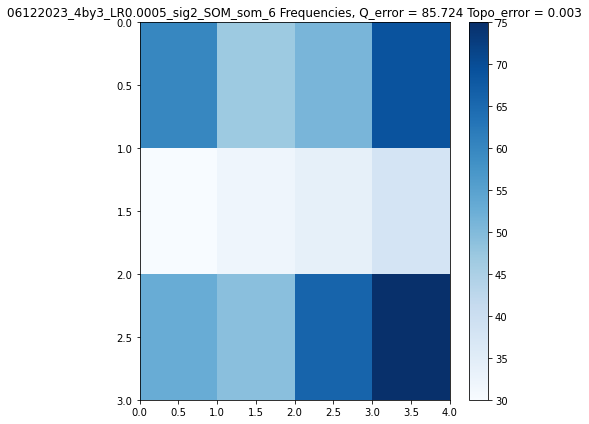

TolFun exceeded: Optimisation terminated


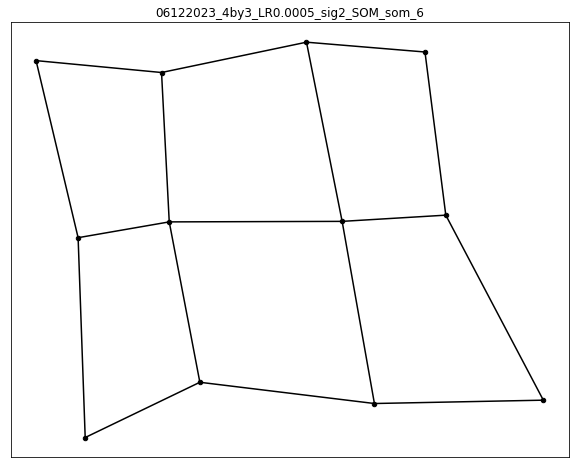

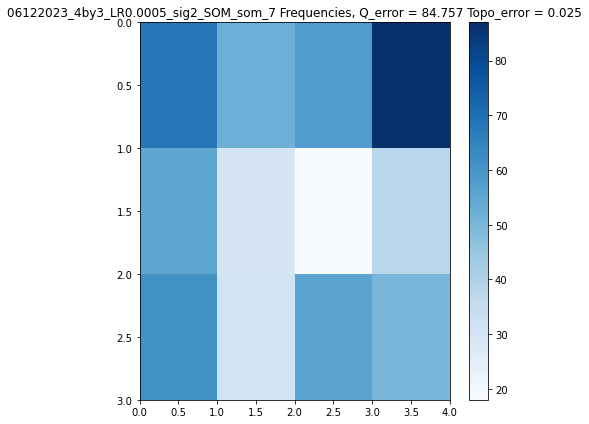

TolFun exceeded: Optimisation terminated


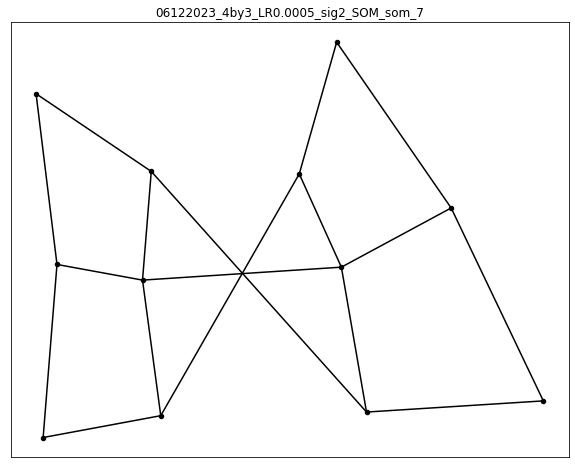

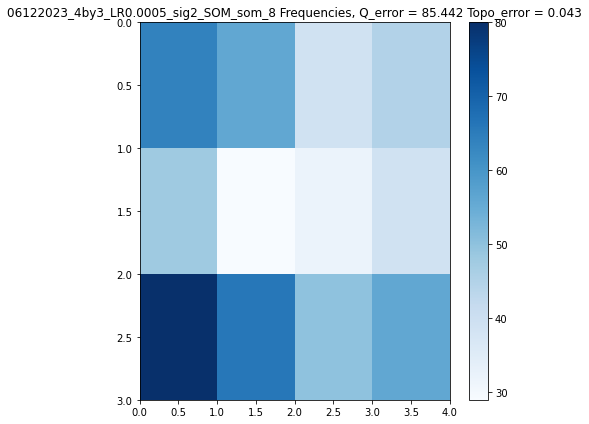

TolFun exceeded: Optimisation terminated


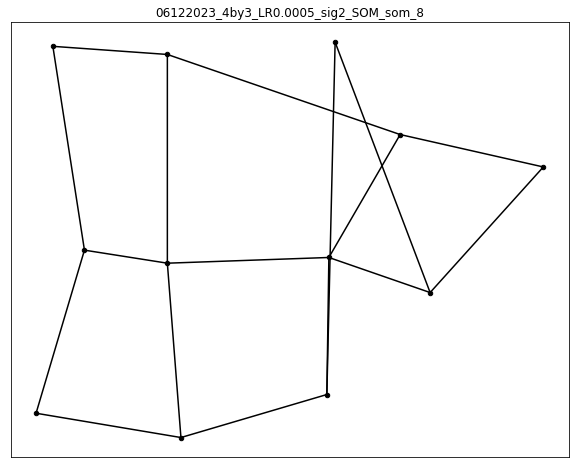

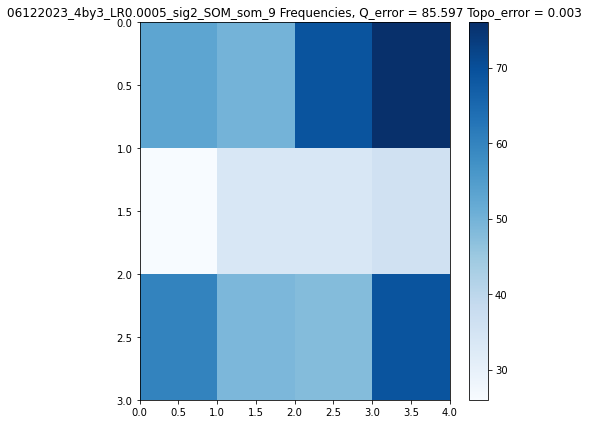

TolFun exceeded: Optimisation terminated


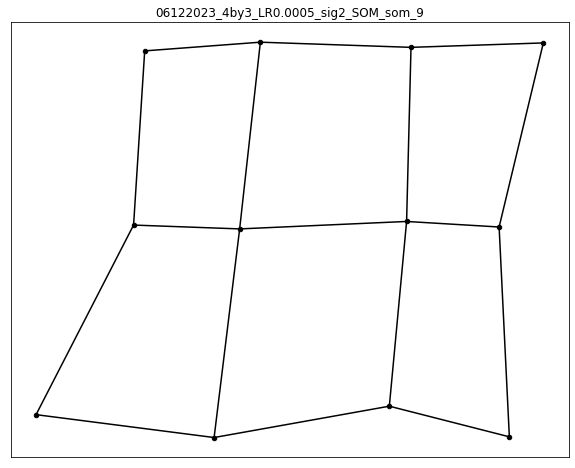

In [97]:
for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        file = pickle.load(f) #This is loading every single som in that location
        frequencies = file.activation_response(data_train) #this is grabbing each freq
        q_error = round(file.quantization_error(data_train),3) #this is grabbing every q error out to 3 decimal places
        topo_error = round(file.topographic_error(data_train),3) #this is grabbing ever topographic error out to 3 decimal places
        plt.figure(figsize=(6,6))
        cs = plt.pcolormesh(frequencies, cmap='Blues')
        plt.title(name + ' ' + 'Frequencies,' + ' ' + 'Q_error =' + ' ' f"{q_error}" + ' ' + 'Topo_error =' + ' ' f"{topo_error}", fontsize=12)

        #in the title, I am plotting every q error and topo error from each som. You need to have the f" in front and whatever variable in {}
        #And this ' ' represents a space in the title
        plt.colorbar(cs)
        plt.ylim(3,0) # Change the 3 to whatever size SOM you have (this is the 2nd number)
        plt.tight_layout()
        plt.savefig(folderpath + 'frequencies_'+name+'.png') #I am saving the outputs as a png file in the same file path and giving it the name of each SOM
        
        plt.show()
        
        [y,E] = sammon(file.get_weights().reshape(som_col*som_row, input_length),2,display=1)

            # Plot Sammon map nodes
        plt.figure(figsize=(10,8))
        plt.scatter(y[:,0], y[:,1], s=20, c='black', marker='o')

            # Add lines between nodes
        mslp = np.reshape(y,(som_row,som_col,2))
        len_x, len_y, len_z = mslp.shape

        # add vertical lines
        for i in range(len_x-1):
            for j in range(len_y):
                plt.plot(mslp[i:i+2,j,0],mslp[i:i+2,j,1],c='black')

        # add horizontal lines
        for i in range(len_x):
            for j in range(len_y-1):
                plt.plot(mslp[i,j:j+2,0],mslp[i,j:j+2,1],c='black')  

        plt.xticks([])
        plt.yticks([])
        plt.title(name, fontsize=12)
        plt.savefig(folderpath + 'sammonplot_'+name+'.png') #I am saving the outputs as a png file in the same file path and giving it the name of each SOM

        plt.show()

We will now loop through and plot the MSLP Anomaly Plots for each SOM. This is how we will visualize the SOM output.
***You will need to update the following lines in the code block below to the dimensions of YOUR SOM.***
Lines: 7, 17,

In [ ]:
for path, name in zip(filepaths, names):
    with open (path, 'rb') as f:
        som = pickle.load(f)
        weights = som._weights

        #Need to create a new dictionary for the new data
        keys = [i for i in product(range(3), range(4))]
        winmap = {key: [] for key in keys}

        for i, x in enumerate(data_train):
            winmap[som.winner(x)].append(i)
            som_keys = getList(winmap)
        frequencies = som.activation_response(data_train)
        datacrs = ccrs.PlateCarree()
        
        #You will set this to the dimensions of the SOM.
        fig, axs = plt.subplots(nrows=3,ncols=4,
                                subplot_kw={'projection':ccrs.LambertConformal(central_longitude=-156, central_latitude=71, standard_parallels=(30, 60))},
                                figsize=(30, 15),facecolor='white') 
        fig.tight_layout()


        axs=axs.flatten()
#############################################################################################################################################################################################################
        
        #THIS IS VERY IMPORTANT you will multiply the "k" in the node = line by the largest value of the SOM so in the case of a 4x3 it will be multiplied by 4. For example,
        #if your SOM was an 8x5 you would multiple the k by 8.
#############################################################################################################################################################################################################
        
        for k in range(weights.shape[0]):
            for i in range(weights.shape[1]):
                #node = (k,i)
                node=(k*4)+i
                SOM_mslp = weights[k,i,:].reshape(nx,ny)
                #levs = np.arange(-10, 10, 2)
                lev_start = -12
                lev_step= 2
                levs = (np.arange(lev_start-(lev_step/2), np.abs(lev_start)+(lev_step/2)+lev_step,lev_step))
                cs2=axs[(k*4)+i].contourf(lon, lat, SOM_mslp,
                                  transform = ccrs.PlateCarree(),
                                  cmap='coolwarm', levels = levs,extend='both')
                axs[(k*4)+i].set_extent([-131.7, -180, 73.48, 62.9], ccrs.PlateCarree() )

                axs[(k*4)+i].coastlines()
                axs[(k*4)+i].add_feature(cfeature.BORDERS) 
                axs[(k*4)+i].scatter(-156.36,71.19, c='yellow',marker= 'o',s=120, linewidth=2,edgecolors= "black" ,zorder= 4,transform=datacrs)


                # Title each subplot 
                axs[(k*4)+i].set_title('Node:'+str(node), fontsize=18)


                plt.tight_layout()
                fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.6,
                            wspace=0.05, hspace=0.25)

        cbar_ax = fig.add_axes([0.08, 0.2, 0.5, 0.02])
        cbar=fig.colorbar(cs2,cax=cbar_ax, ticks = np.arange(lev_start, np.abs(lev_start)+lev_step, lev_step*2),orientation='horizontal')

        cbar.set_label('MSLP (hPa)', fontsize=22)

        plt.suptitle('SOM Nodes: MSLP Anomalies (hPa). '+name+'', x= 0.33 ,fontsize=22)   
        plt.savefig(folderpath + 'anomalyplot_'+name+'.png', bbox_inches='tight')
        plt.show()

    

The End!